In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from kafka import KafkaConsumer
from sklearn.metrics import f1_score
from sklearn.feature_extraction import FeatureHasher

In [3]:
# Define Data Consumer Portal To Kafka Server So we can retrieve Streamed Data
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Define The Data Metadata(Columns Name, Data Type) As Columns Data Type aren't included in the Streamed Data To allow us to convert the data to the right format
# Columns Name
col_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
# Columns to convert to 'int64'
int_columns = ['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'special', 'labels', 'labels_max', 'len', 'subdomain', 'Target Attack']
# Columns to convert to 'float64'
float_columns = ['entropy', 'labels_average']

### Discard First Row of Data Stream As It Contains Column Names & we Already Defined Them

In [4]:
for m in consumer:
    print(m.value)
    break

b'"\\u00ef\\u00bb\\u00bftimestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack\\n"'


# Helper Functions

### Function Returns the Previously Fitted Best Model in Static Model Building

In [5]:
def load_best_model(model_name='ANOVA_23_xgb_model.pkl'):
    with open(model_name, 'rb') as f:
        best_model_pipeline = pickle.load(f)
    return best_model_pipeline

### Function Takes this Specific Dataset & Returns:
Target Column, Binary Columns, Numeric Columns & Categorical Columns Names based on the data analysis done in the notebook

In [6]:
def categorise_data_columns(data):
    target_column, binary_columns = 'Target Attack', ['subdomain']
    numeric_columns = list(set(data.select_dtypes(include=['int64', 'float64']).columns) - set([target_column] + binary_columns))
    categorical_columns = list(set(data.select_dtypes(include=['object', 'bool']).columns) - set(numeric_columns + binary_columns + [target_column]))
    return target_column, binary_columns, numeric_columns, categorical_columns

### Function That Apply Required Data Preprocessing Steps on the Dataframe to prepare it for Normalization & Modeling
Dropping Nulls<br>
Transforming Timestamp to standard measuring unit fraction of seconds<br>
Split features & target<br>
Hash Encoding sld & longest_word categorical features into passed number of hash components (defualt: 16)<br>
& returns preprocessed features, & names of target, binary(0 or 1), numeric & hashed categorical columns

In [7]:
def preprocess_data(data, n_hash_components = 2**4):

    # Define the hashing transformer
    hasher = FeatureHasher(n_features=n_hash_components, input_type='string')
    data_copy = data.copy()
    # Drop null values
    data_copy.dropna(inplace=True)
    data_copy.reset_index(drop=True, inplace=True)

    # Transform timestamp into aggregated form of it's components
    timestamp_pattern = r'(\d+):(\d+)\.(\d+)'
    timestamp_components = pd.DataFrame(data_copy['timestamp'].str.extract(timestamp_pattern).values.tolist(), index=data_copy.index, columns=['min', 'sec', 'sec_frac'])
    data_copy['timestamp'] = timestamp_components['min'].astype('Int64') * 60 * 10 + timestamp_components['sec'].astype('Int64') * 10 + timestamp_components['sec_frac'].astype('Int64')
    
    # Prepare Different Categories of Columns
    target_column, binary_columns, numeric_columns, categorical_columns = categorise_data_columns(data_copy)
    hash_columns=[f'hash_comp_{i}' for i in range(n_hash_components)]

    #split data into X & y
    y = data_copy[target_column]
    X = data_copy.drop(target_column, axis=1)

    # Prepare Categorical Columns for Hashing
        # Create column combined_cat that combine both values of the two categorical values of same record in single list to prepare it for hashing
    X['combined_cat'] = X[categorical_columns].astype(str).values.tolist()
        # Replace categorical columns with hashed columns
    X.drop(categorical_columns, axis=1, inplace=True)
    
    # Hash Categorical Columns
    hash_comp = hasher.transform(X['combined_cat'])
    # Save Them to DataFrame
    hash_comp = pd.DataFrame(hash_comp.toarray(), columns=hash_columns)
    # Drop combined_cat column
    X.drop('combined_cat', axis=1, inplace=True)

    # Combine Hashed Columns with X
    X_preprocessed = pd.concat([X, hash_comp], axis=1)
    
    return X_preprocessed, y, target_column, binary_columns, numeric_columns, hash_columns


### Function that Retreives a Data Batch or Number of Records (defualt: 1000) from the Data Streamed by Through the Passed Consumer

In [8]:
def stream_batch(itr, consumer, num_of_rec=1e3):
    rec_counts, rec_batch_list = 0, []
    for c in consumer:
        if rec_counts < num_of_rec:
            rec_batch_list.append(c.value)
            rec_counts = rec_counts + 1
        else:   break
    print(f"Window {itr}")

    return rec_batch_list      

### Function that Parses the Passed Batch of Raw Data into a Dataframe With Standard Columns Names & Data Types 

In [9]:
def parse_batch_to_df(raw_batch):
    batch_df = pd.DataFrame()
    list_of_rec = [eval(item.decode("UTF-8")).strip().split(",") for item in raw_batch]
    batch_df=pd.DataFrame(list_of_rec)
    # set column names
    batch_df.columns=col_names
    # Convert int columns to int64 type instead of object
    batch_df[int_columns] = batch_df[int_columns].astype('int64')
    # Convert to 'float64'
    batch_df[float_columns] = batch_df[float_columns].astype('float64')
    
    return batch_df

### Function that Retrain Passed Model on the Passed Batch of Data

In [10]:
def retrain(X, y, model):   return model.fit(X, y)

# Static & Dynamic Models Application On Streaming Data

### Load Static Dataset for Use in Retraining the Dynamic Model

In [11]:
static_data = pd.read_csv("Static_dataset.csv")
X_retraining, y_retraining, target_column, binary_columns, numeric_columns, hash_columns = preprocess_data(static_data) 

### Load the Previously Fitted Best Model in Static Model & Dynamic Model As Intial Model & Set Dynamic Model Retraining Threshold
to 0.85 f1-socre this because at first we experimented a threadhold of 0.8 since actual static model performance on static test data was 0.81 so we thought it wouldn't tolerate 0.01 lower performance but it was too low & the model was not able to detect any drifts in the data as static model performance on streaming data was higher than 0.81 which resulted the dynamic model to remain static. So we increased the threadhold to 0.85.<br>
we setted the num_of_batches to consume to 265 as total number or records in streaming data is aproximately 265000 & we setted the batch_size to 1000 this require consuming the data in 265 batches.

In [12]:
f1_score_retraining_threshold, num_batches = 0.85, 265
static_model_f1_scores, dynamic_model_f1_scores = [], []
static_model, dynamic_model = load_best_model('ANOVA_23_xgb_model.pkl'), load_best_model('ANOVA_23_xgb_model.pkl')

### Consume Streamed Data in Batches & Record Static & Dynamic Model Performance on Each Batch
The stratgy used to retrain the dynamic model is that each time the model performance on a certain batch is below the defined threshold this batch is accumelated over the previously batches that also resulted in a performance drop & the model is retrained on those accumlated performance drop batches in addition to static data.

In [13]:
for itr in range(1, num_batches):
    raw_batch = stream_batch(itr, consumer)
    batch_df = parse_batch_to_df(raw_batch)
    X_preprocessed_batch, y_batch, target_column, binary_columns, numeric_columns, hash_columns = preprocess_data(batch_df)

    dynamic_model_pred = dynamic_model.predict(X_preprocessed_batch)
    dynamic_model_f1 = f1_score(y_batch, dynamic_model_pred)
    print(f"The F1 Score of Dynamic Model without retrain = {dynamic_model_f1}")
    
    if dynamic_model_f1 < f1_score_retraining_threshold:
        print(f"{'*'*5}\nRetraining the Dynamic Model On Last Streamed Batch...")
        # Accumulate the new batch to the training data as it's the batch that the model will performance on it was below the threshold
        X_retraining = pd.concat([X_retraining, X_preprocessed_batch], axis=0)
        y_retraining = pd.concat([y_retraining, y_batch], axis=0)
        # Retrain the model on the new batch & previously missed batches in addition to static data
        dynamic_model_pred = retrain(X_preprocessed_batch, y_batch, dynamic_model)
        # Evaluate the retrained model
        dynamic_model_pred = dynamic_model.predict(X_preprocessed_batch)
        dynamic_model_f1 = f1_score(y_batch, dynamic_model_pred)
        print(f"The f1 of Dynamic Model after retrain = {dynamic_model_f1}")
    
    static_model_pred = static_model.predict(X_preprocessed_batch)
    static_model_f1=f1_score(y_batch, static_model_pred)
    print(f"The F1 of Static Model = {static_model_f1}")
    static_model_f1_scores.append(static_model_f1)
    dynamic_model_f1_scores.append(dynamic_model_f1)
    print(f"{'*'*10}")


Window 1
The F1 Score of Dynamic Model without retrain = 0.8451612903225806
*****
Retraining the Dynamic Model On Last Streamed Batch...
The f1 of Dynamic Model after retrain = 0.9629629629629629
The F1 of Static Model = 0.8451612903225806
**********
Window 2
The F1 Score of Dynamic Model without retrain = 0.7633451957295374
*****
Retraining the Dynamic Model On Last Streamed Batch...
The f1 of Dynamic Model after retrain = 0.9644128113879004
The F1 of Static Model = 0.8560126582278482
**********
Window 3
The F1 Score of Dynamic Model without retrain = 0.7623931623931623
*****
Retraining the Dynamic Model On Last Streamed Batch...
The f1 of Dynamic Model after retrain = 0.8428459734167317
The F1 of Static Model = 0.8407148407148406
**********
Window 4
The F1 Score of Dynamic Model without retrain = 0.8513618677042801
The F1 of Static Model = 0.8608762490392006
**********
Window 5
The F1 Score of Dynamic Model without retrain = 0.837246963562753
*****
Retraining the Dynamic Model On Las

### Plot F1 Score of Dynamic Model Vs Static Model Over Streamed Batches

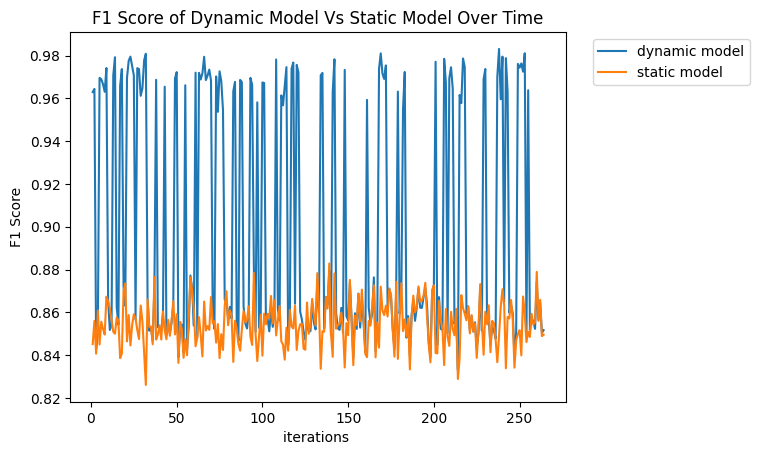

In [14]:
plt.plot(range(1, 265), dynamic_model_f1_scores, label=f'dynamic model')
plt.plot(range(1, 265),static_model_f1_scores, label=f'static model')
plt.title("F1 Score of Dynamic Model Vs Static Model Over Time")
plt.xlabel('iterations ')
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

### Compare Static & Dynamic Models Performance on Average for Streaming Data

Average F1 score of dynamic model = 0.8984494110039937
Average F1 score of static model = 0.8544961905761449


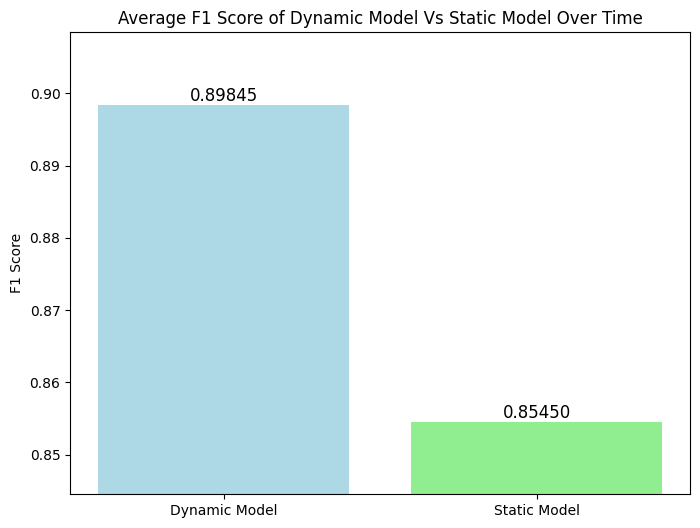

In [16]:
# calculate the average F1 score of dynamic and static models
avg_dynamic_f1 = sum(dynamic_model_f1_scores) / len(dynamic_model_f1_scores)
avg_static_f1 = sum(static_model_f1_scores) / len(static_model_f1_scores)

# Print the average F1 scores
print(f'Average F1 score of dynamic model = {avg_dynamic_f1}')
print(f'Average F1 score of static model = {avg_static_f1}')

# Show F1-scores comparison
plt.figure(figsize=(8, 6))
plt.bar(['Dynamic Model', 'Static Model'], [avg_dynamic_f1, avg_static_f1], color=['lightblue', 'lightgreen'])
plt.ylabel('F1 Score')
plt.title('Average F1 Score of Dynamic Model Vs Static Model Over Time')
plt.ylim([min([avg_dynamic_f1, avg_static_f1]) - 0.01, max([avg_dynamic_f1, avg_static_f1]) + 0.01])

# Annotate the bars with their respective accuracy values
for i, v in enumerate([avg_dynamic_f1, avg_static_f1]):
    plt.text(i, v, f'{v:.5f}', ha='center', va='bottom', fontsize=12)

plt.show()


The average performance of dynamic model on all streamed batches is significantly higher than the static model performance on static test data